<b>Project name:</b> Rock, Paper, Scissors, Lizard, Spock

<b>Authors:</b> Jovana Radjenovic, Zorana Aleksic

# Installation

In [ ]:
#conda install -c conda-forge keras

In [ ]:
#conda install -c conda-forge tensorflow

In [1]:
#pip install opencv-python

# Import Libraries

In [1]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn import model_selection
from matplotlib import pyplot as plt
from PIL import Image,ImageEnhance
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import  CategoricalCrossentropy
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Activation, Flatten, Dense, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization

In [2]:
main_directory = 'dataset'

In [3]:
class_map = {
    "rock": 0,
    "paper": 1,
    "scissors": 2,
    "lizard": 3,
    "spock": 4,
    "nothing": 5
}

# Dataset information:
- 3000 images which consist of 6 categories (each category has 500 images)
- image sizes: 300x300 and 400x380, will be resized to 300x300
<br/><br/> More info on wiki page

# Load data
Resize images to 300x300 and change color to gray.

In [4]:
dataset = []
for directory in os.listdir(main_directory):
    path = os.path.join(main_directory, directory)
    if not os.path.isdir(path):
        continue
    for item in os.listdir(path):
        # sharpen images
        #image = Image.open("{}".format(os.path.join(path, item)))
        #enhancer = ImageEnhance.Sharpness(image)
        #image = enhancer.enhance(2)
        #image.save("{}".format(os.path.join(path, item)))
        
        image = cv2.imread(os.path.join(path, item))
        image = cv2.resize(image, (300,300))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        dataset.append([image, directory])

# Show Examples

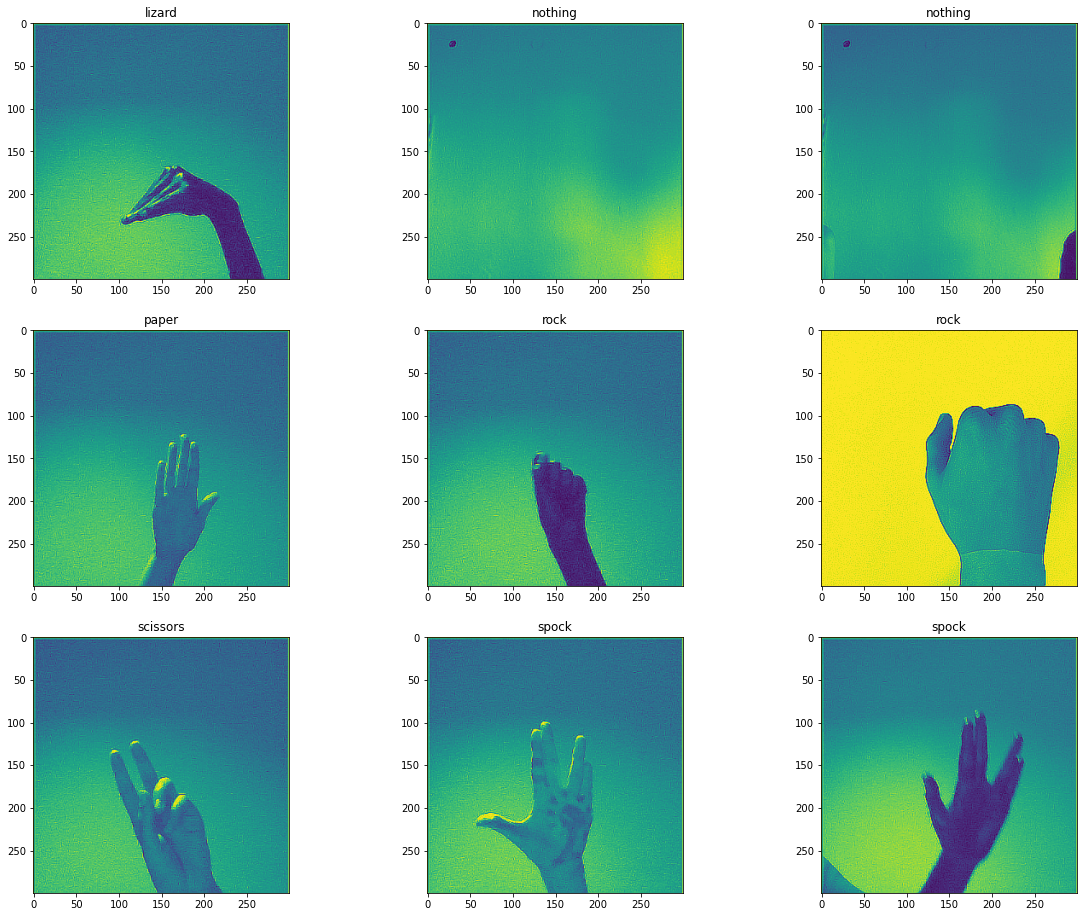

In [5]:
fig = plt.figure(figsize=(20,16))
for i in range(1, 10):
        fig.add_subplot(3, 3, i)
        image = dataset[i*333][0]
        plt.title(dataset[i*333][1])
        plt.imshow(image)
plt.show()

# Data preparation

In [5]:
dataset = shuffle(dataset, random_state = 0)

In [6]:
data, labels = zip(*dataset)
target = []
for label in labels:
    target.append(class_map[label])

In [7]:
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(data, target, test_size = 0.33, \
                                                                            stratify = target, random_state = 0)

In [8]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train_val, y_train_val, test_size = 0.2, \
                                                                            stratify = y_train_val, random_state = 0)

In [9]:
x_train = np.array(x_train).astype('float32') / 255
x_val = np.array(x_val).astype('float32') / 255
x_test = np.array(x_test).astype('float32') / 255

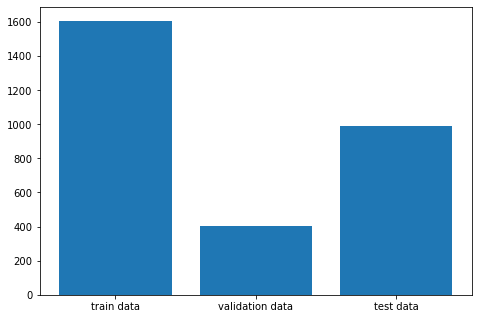

In [25]:
train_size = x_train.shape[0]
val_size=x_val.shape[0]
test_size = x_test.shape[0]
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
names = ["train data", "validation data","test data"]
sizes = [train_size,val_size, test_size]
ax.bar(names,sizes)
plt.show()

In [10]:
num_of_classes = len(class_map)
y_train = utils.to_categorical(y_train, num_of_classes)
y_val = utils.to_categorical(y_val, num_of_classes)
y_test = utils.to_categorical(y_test, num_of_classes)

In [11]:
x_train = x_train.reshape(x_train.shape[0], 300, 300, 1)
x_val = x_val.reshape(x_val.shape[0], 300, 300, 1)
x_test = x_test.reshape(x_test.shape[0], 300, 300, 1)

# Initial convolutional neural network

In [13]:
model = Sequential([
    InputLayer(input_shape=(300,300,1)),
    Convolution2D(64, 3, activation='relu'),
    Convolution2D(32, 3, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 296, 296, 32)      18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 148, 148, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 700928)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               89718912  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
51/51 [==============================] - 340s 7s/step - loss: 1.8299 - accuracy: 0.3078 - val_loss: 1.4946 - val_accuracy: 0.4254
Epoch 2/10
51/51 [==============================] - 362s 7s/step - loss: 1.1782 - accuracy: 0.6088 - val_loss: 0.9657 - val_accuracy: 0.6716
Epoch 3/10
51/51 [==============================] - 364s 7s/step - loss: 0.7222 - accuracy: 0.7749 - val_loss: 0.6848 - val_accuracy: 0.7687
Epoch 4/10
51/51 [==============================] - 365s 7s/step - loss: 0.4733 - accuracy: 0.8588 - val_loss: 0.6061 - val_accuracy: 0.7687
Epoch 5/10
51/51 [==============================] - 353s 7s/step - loss: 0.3326 - accuracy: 0.9129 - val_loss: 0.3734 - val_accuracy: 0.8682
Epoch 6/10
51/51 [==============================] - 375s 7s/step - loss: 0.2225 - accuracy: 0.9552 - val_loss: 0.3144 - val_accuracy: 0.9030
Epoch 7/10
51/51 [==============================] - 370s 7s/step - loss: 0.1700 - accuracy: 0.9658 - val_loss: 0.2967 - val_accuracy: 0.9104
Epoch 8/10
51

## Model evaluation and analysis

In [17]:
model_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', model_score[0])
print('Test accuracy:', model_score[1])

Test loss: 0.21185302734375
Test accuracy: 0.9333333373069763


In [18]:
classification_report_model=classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=-1))
print(classification_report_model)

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       165
           1       0.86      0.92      0.89       165
           2       0.92      0.90      0.91       165
           3       0.97      0.95      0.96       165
           4       0.92      0.95      0.93       165
           5       1.00      1.00      1.00       165

    accuracy                           0.93       990
   macro avg       0.93      0.93      0.93       990
weighted avg       0.93      0.93      0.93       990



In [19]:
confusion_matrix_model=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=-1))
print(confusion_matrix_model)

[[147  10   4   3   1   0]
 [  2 151   3   0   9   0]
 [  7  10 148   0   0   0]
 [  1   2   2 157   3   0]
 [  0   3   4   2 156   0]
 [  0   0   0   0   0 165]]


## Accuracy and loss function graph

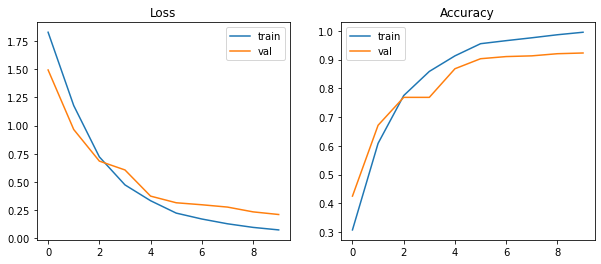

In [30]:
epochs=10
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

# Second convolutional neural network

In [28]:
model2 = Sequential([
    InputLayer(input_shape=(300,300,1)),
    Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [29]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 300, 300, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 37, 37, 128)      

In [30]:
model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])


In [31]:
history2=model2.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
51/51 [==============================] - 135s 3s/step - loss: 1.6982 - accuracy: 0.2998 - val_loss: 1.4179 - val_accuracy: 0.5323
Epoch 2/10
51/51 [==============================] - 138s 3s/step - loss: 1.2750 - accuracy: 0.5075 - val_loss: 0.9648 - val_accuracy: 0.7114
Epoch 3/10
51/51 [==============================] - 132s 3s/step - loss: 0.9041 - accuracy: 0.6779 - val_loss: 0.6150 - val_accuracy: 0.8383
Epoch 4/10
51/51 [==============================] - 133s 3s/step - loss: 0.6585 - accuracy: 0.7718 - val_loss: 0.4425 - val_accuracy: 0.8582
Epoch 5/10
51/51 [==============================] - 133s 3s/step - loss: 0.4968 - accuracy: 0.8240 - val_loss: 0.3606 - val_accuracy: 0.8955
Epoch 6/10
51/51 [==============================] - 133s 3s/step - loss: 0.4062 - accuracy: 0.8632 - val_loss: 0.2580 - val_accuracy: 0.9154
Epoch 7/10
51/51 [==============================] - 134s 3s/step - loss: 0.3091 - accuracy: 0.8943 - val_loss: 0.2161 - val_accuracy: 0.9328
Epoch 8/10
51

## Model evaluation and analysis

In [32]:
model2_score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', model2_score[0])
print('Test accuracy:', model2_score[1])

Test loss: 0.15701064467430115
Test accuracy: 0.9515151381492615


In [33]:
classification_report_model2=classification_report(np.argmax(y_test, axis=1), np.argmax(model2.predict(x_test), axis=-1))
print(classification_report_model2)

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       165
           1       0.89      0.97      0.93       165
           2       0.97      0.88      0.93       165
           3       0.95      0.97      0.96       165
           4       0.99      0.96      0.97       165
           5       1.00      1.00      1.00       165

    accuracy                           0.95       990
   macro avg       0.95      0.95      0.95       990
weighted avg       0.95      0.95      0.95       990



In [34]:
confusion_matrix_model2=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model2.predict(x_test), axis=-1))
print(confusion_matrix_model2)

[[153   4   3   5   0   0]
 [  3 160   0   2   0   0]
 [  8  10 146   1   0   0]
 [  1   2   0 160   2   0]
 [  2   3   1   1 158   0]
 [  0   0   0   0   0 165]]


## Accuracy and loss function graph

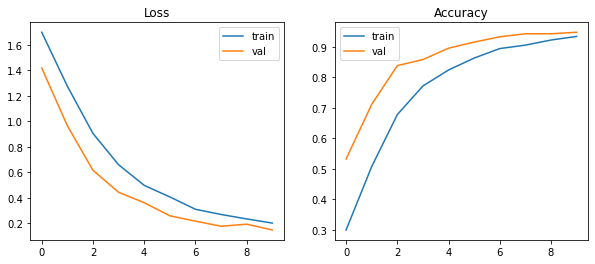

In [35]:
epochs=10
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history2.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history2.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history2.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history2.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

## Save model

In [36]:
model2.save('models/model2.hdf5')

# Hyperparameter Tuning

In [ ]:
#pip install -U keras_tuner

In [27]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()

    model.add(MaxPooling2D((6,6),3,input_shape=(300,300,1)))

    for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
         model.add(Convolution2D(hp.Choice(f"layer_{i}_filters", [16,32,64]), 3, activation='relu'))
  
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.5))
    model.add(Flatten())

    model.add(Dense(hp.Choice("Dense layer", [64, 128, 256, 512, 1024]), activation='relu'))

    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
  
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=32,
)

tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

Trial 32 Complete [00h 08m 21s]
val_accuracy: 0.8855721354484558

Best val_accuracy So Far: 0.9527363181114197
Total elapsed time: 02h 21m 43s
INFO:tensorflow:Oracle triggered exit


In [29]:
best_model=tuner.get_best_models()[0]

In [30]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (None, 99, 99, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 97, 97, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 95, 95, 16)        9232      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 93, 93, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0

In [93]:
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]

In [95]:
best_model = tuner.hypermodel.build(bestHP)
history_best_model = best_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
51/51 [==============================] - 43s 845ms/step - loss: 1.7253 - accuracy: 0.3041 - val_loss: 1.5166 - val_accuracy: 0.5348
Epoch 2/10
51/51 [==============================] - 43s 841ms/step - loss: 1.2068 - accuracy: 0.5939 - val_loss: 0.9518 - val_accuracy: 0.6816
Epoch 3/10
51/51 [==============================] - 43s 848ms/step - loss: 0.7053 - accuracy: 0.7817 - val_loss: 0.6093 - val_accuracy: 0.8134
Epoch 4/10
51/51 [==============================] - 43s 836ms/step - loss: 0.4298 - accuracy: 0.8881 - val_loss: 0.4092 - val_accuracy: 0.8682
Epoch 5/10
51/51 [==============================] - 46s 903ms/step - loss: 0.2787 - accuracy: 0.9322 - val_loss: 0.3439 - val_accuracy: 0.8980
Epoch 6/10
51/51 [==============================] - 46s 896ms/step - loss: 0.1870 - accuracy: 0.9496 - val_loss: 0.2788 - val_accuracy: 0.9055
Epoch 7/10
51/51 [==============================] - 51s 1s/step - loss: 0.1197 - accuracy: 0.9745 - val_loss: 0.2770 - val_accuracy: 0.9129
Ep

## Model evaluation and analysis

In [96]:
best_model_score = best_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', best_model_score[0])
print('Test accuracy:', best_model_score[1])

Test loss: 0.19686174392700195
Test accuracy: 0.9414141178131104


In [97]:
classification_report_best_model=classification_report(np.argmax(y_test, axis=1), np.argmax(best_model.predict(x_test), axis=-1))
print(classification_report_best_model)

              precision    recall  f1-score   support

           0       0.88      0.95      0.92       165
           1       0.92      0.90      0.91       165
           2       0.92      0.84      0.88       165
           3       0.97      0.98      0.98       165
           4       0.96      0.98      0.97       165
           5       1.00      1.00      1.00       165

    accuracy                           0.94       990
   macro avg       0.94      0.94      0.94       990
weighted avg       0.94      0.94      0.94       990



In [98]:
confusion_matrix_best_model=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(best_model.predict(x_test), axis=-1))
print(confusion_matrix_best_model)

[[157   2   6   0   0   0]
 [  3 148   4   3   7   0]
 [ 14  11 139   1   0   0]
 [  2   0   1 162   0   0]
 [  2   0   1   1 161   0]
 [  0   0   0   0   0 165]]


## Accuracy and loss function graph

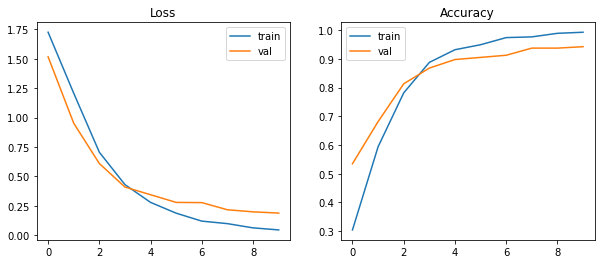

In [99]:
epochs=10
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history_best_model.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history_best_model.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history_best_model.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history_best_model.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

## Save model

In [100]:
best_model.save('models/best_model.hdf5')

# AlexNet model

In [13]:
alexnet_model = Sequential()
alexnet_model.add(Convolution2D(filters=96, input_shape=(300,300,1), kernel_size=(11,11), strides=(4,4), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

alexnet_model.add(Convolution2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

alexnet_model.add(Convolution2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))

alexnet_model.add(Convolution2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))

alexnet_model.add(Convolution2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

alexnet_model.add(Flatten())
alexnet_model.add(Dense(4096, input_shape=(300,300,1)))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.4))
alexnet_model.add(Dense(4096))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.4))

alexnet_model.add(Dense(1000))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.4))

alexnet_model.add(Dense(6))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('softmax'))

In [14]:
alexnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 75, 75, 96)        11712     
_________________________________________________________________
batch_normalization_9 (Batch (None, 75, 75, 96)        384       
_________________________________________________________________
activation_9 (Activation)    (None, 75, 75, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 38, 38, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 38, 38, 256)       614656    
_________________________________________________________________
batch_normalization_10 (Batc (None, 38, 38, 256)       1024      
_________________________________________________________________
activation_10 (Activation)   (None, 38, 38, 256)      

In [15]:
alexnet_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [16]:
alexnet_history = alexnet_model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val,y_val))

Epoch 1/10
13/13 [==============================] - 221s 17s/step - loss: 1.0953 - accuracy: 0.6387 - val_loss: 17.6518 - val_accuracy: 0.1667
Epoch 2/10
13/13 [==============================] - 216s 17s/step - loss: 0.5474 - accuracy: 0.9055 - val_loss: 5.2189 - val_accuracy: 0.1667
Epoch 3/10
13/13 [==============================] - 218s 17s/step - loss: 0.4164 - accuracy: 0.9639 - val_loss: 3.3695 - val_accuracy: 0.2687
Epoch 4/10
13/13 [==============================] - 216s 17s/step - loss: 0.3624 - accuracy: 0.9876 - val_loss: 2.0864 - val_accuracy: 0.2015
Epoch 5/10
13/13 [==============================] - 218s 17s/step - loss: 0.3252 - accuracy: 0.9969 - val_loss: 1.6763 - val_accuracy: 0.3532
Epoch 6/10
13/13 [==============================] - 216s 17s/step - loss: 0.2923 - accuracy: 1.0000 - val_loss: 2.0548 - val_accuracy: 0.2960
Epoch 7/10
13/13 [==============================] - 215s 17s/step - loss: 0.2797 - accuracy: 1.0000 - val_loss: 1.7971 - val_accuracy: 0.3134
Epoch

## Model evaluation and analysis

In [17]:
alexnet_model_score = alexnet_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', alexnet_model_score[0])
print('Test accuracy:', alexnet_model_score[1])

Test loss: 2.1537487506866455
Test accuracy: 0.20606060326099396


In [18]:
classification_report_alexnet_model = classification_report(np.argmax(y_test, axis=1), 
                                                            np.argmax(alexnet_model.predict(x_test), axis=-1))
print(classification_report_alexnet_model)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.00      0.00      0.00       165
           2       0.18      0.88      0.29       165
           3       0.00      0.00      0.00       165
           4       0.00      0.00      0.00       165
           5       0.36      0.35      0.35       165

    accuracy                           0.21       990
   macro avg       0.09      0.21      0.11       990
weighted avg       0.09      0.21      0.11       990



C:\Users\DeveloperK\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
confusion_matrix_alexnet_model = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(alexnet_model.predict(x_test), axis=-1))
print(confusion_matrix_alexnet_model)

[[  0   0 108   0   0  57]
 [  0   0 137   0   0  28]
 [  0   0 146   0   0  19]
 [  0   0 165   0   0   0]
 [  0   0 165   0   0   0]
 [  0   0 107   0   0  58]]


# Accuracy and loss function graph

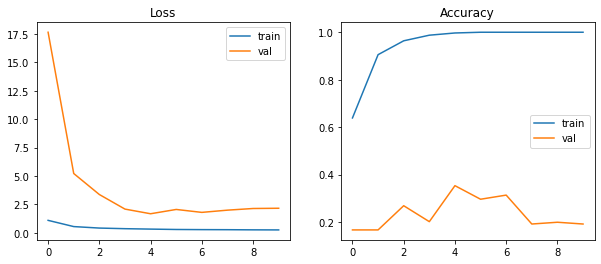

In [20]:
epochs=10
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), alexnet_history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), alexnet_history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), alexnet_history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), alexnet_history.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

## Save model

In [21]:
alexnet_model.save('models/alexnet_model.hdf5')

# Game

In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from random import choice

In [ ]:
class_map = {
    0: "rock",
    1: "paper",
    2: "scissors",
    3: "lizard",
    4: "spock",
    5: "nothing"
}

In [ ]:
def class_name(index):
    return class_map[index]

In [ ]:
#staviti pre ovoga proveru da li je nothing move1 ili move2
def who_wins(move1, move2, player1, player2):
    if move1 == move2:
        return "Tie"

    if move1 == "rock":
        if move2 == "paper":
            return player2
        if move2 == "scissors":
            return player1
        if move2 == "lizard":
            return player1
        if move2 == "spock":
            return player2

    if move1 == "paper":
        if move2 == "rock":
            return player1
        if move2 == "scissors":
            return player2
        if move2 == "lizard":
            return player2
        if move2 == "spock":
            return player1

    if move1 == "scissors":
        if move2 == "rock":
            return player2
        if move2 == "paper":
            return player1
        if move2 == "lizard":
            return player1
        if move2 == "spock":
            return player2
        
    if move1 == "lizard":
        if move2 == "rock":
            return player2
        if move2 == "paper":
            return player1
        if move2 == "scissors":
            return player2
        if move2 == "spock":
            return player1

    if move1 == "spock":
        if move2 == "rock":
            return player1
        if move2 == "paper":
            return player2
        if move2 == "scissors":
            return player1
        if move2 == "lizard":
            return player2

In [ ]:
captured_image = cv2.VideoCapture(0) # 0 -> open default camera

In [ ]:
prev_move = None

while True:
    retval, frame = captured_image.read() # Grabs, decodes and returns the next video frame.
    if not retval:
        continue
    
    frame = cv2.flip(frame, 1)
    
    window_height = frame.shape[0]
    window_width = frame.shape[1]
    
    # rectangle for user to play
    #def: cv2.rectangle(image, start_point, end_point, color, thickness), we set color in RGB format
    cv2.rectangle(frame, (0, 0), (int(window_width * .40), int(window_height * .60)), (255, 255, 255), 2) 
    # rectangle for computer to play
    cv2.rectangle(frame, (int(window_width * .60), 0), (window_width, int(window_height * .60)), (255, 255, 255), 2)
    
    window_name = "Rock Paper Scissors Lizard Spock"
    cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
    cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

    # extract the region of image within the user rectangle
    roi = frame[0:int(window_height * .60), 0:int(window_width * .40)]
    
    # TODO: delete
    import matplotlib.pyplot as plt
    plt.imshow(roi)
    plt.show()
    
    img = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (300, 300))
    
    # additional preparation of data
    img = img.reshape(300, 300, 1)
    img = np.array([img]).astype('float32')
    img /= 255
    
    # predict the move made
    pred = model.predict(img)
    move_class = np.argmax(pred[0])
    print(pred[0], move_class) # TODO: delete
    user_move_name = class_name(move_class)
    
    print(prev_move, user_move_name) # TODO: delete
    
    # predict the winner (human vs computer)
    if prev_move != user_move_name:
        if user_move_name != "nothing":
            computer_move_name = choice(['rock', 'paper', 'scissors', 'lizard', 'spock'])
            winner = who_wins(user_move_name, computer_move_name, "User", "computer")
        else:
            computer_move_name = "nothing"
            winner = "Waiting..."
    prev_move = user_move_name

    # display the information
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, "Your Move: " + user_move_name,
                (int(window_width * .05), int(window_height * .65)),
                font, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, "Computer's Move: " + computer_move_name,
                (int(window_width * .65), int(window_height * .65)),
                font, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, "Winner: " + winner,
                (int(window_width * .40), int(window_height * .90)),
                font, 0.75, (0, 0, 255), 4, cv2.LINE_AA)

    if computer_move_name != "nothing":
        icon = cv2.imread(
            "images/{}.png".format(computer_move_name))
        icon = cv2.resize(icon, (int(window_width-int(window_width * .60)), int(window_height * .60)))

        frame[0:int(window_height * .60), int(window_width * .60):window_width] = icon

    cv2.imshow(window_name, frame)

    k = cv2.waitKey(10)
    if k == ord('q'):
        break

captured_image.release()
cv2.destroyAllWindows()